In [2]:
# read parquets
import pandas as pd

df_price = pd.read_parquet("../data/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet").reset_index()
df_price_generated_00257 = pd.read_parquet("../data/scenarios synthetiques/prix/00257.parquet")

In [3]:
print(df_price.index.min())
print(df_price.index.max())
df_price.head()

0
35063


,date,price
0,2016-12-31 23:00:00+00:00,58.82
1,2017-01-01 00:00:00+00:00,58.23
2,2017-01-01 01:00:00+00:00,51.95
3,2017-01-01 02:00:00+00:00,47.27
4,2017-01-01 03:00:00+00:00,45.49


In [4]:
print(df_price_generated_00257["dayofweek"].min())
print(df_price_generated_00257["dayofweek"].max())
df_price_generated_00257.head()

0
6


,price,dayofweek,hourofday
0,31.66,0,0
1,31.06,0,1
2,27.81,0,2
3,27.54,0,3
4,25.04,0,4


Change format of the df "donnees historiques" to have the same format as the df "scenarios synthetiques"

In [5]:
df_price['dayofweek'] = df_price['date'].dt.dayofweek
df_price['hourofday'] = df_price['date'].dt.hour
df_price = df_price.drop(columns=["date"])

In [6]:
df_price.head()

,price,dayofweek,hourofday
0,58.82,5,23
1,58.23,6,0
2,51.95,6,1
3,47.27,6,2
4,45.49,6,3


In [7]:
def split_data(df, horizon, x_keys, y_keys):
    X = df[x_keys]
    y = df[y_keys]
    
    X_train = X[:-horizon]
    y_train = y[:-horizon]
    X_test = X[-horizon:]
    y_test = y[-horizon:]

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_data(df_price, 24, ["dayofweek", "hourofday"], "price")

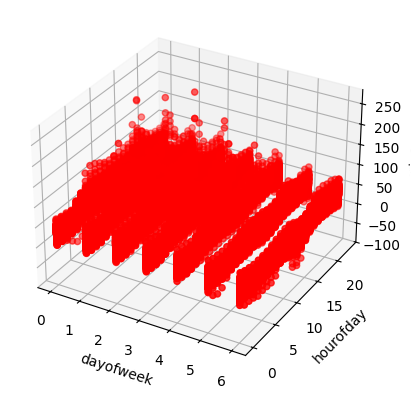

In [8]:
# plot X and Y in 3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train["dayofweek"], X_train["hourofday"], y_train, c='r', marker='o')

ax.set_xlabel('dayofweek')
ax.set_ylabel('hourofday')
ax.set_zlabel('price')

plt.show()

In [9]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
xgb_model = xgb.XGBRegressor()

reg_cv = GridSearchCV(xgb_model, {'max_depth': [1,10], 'n_estimators': [100, 800]}, verbose=1)
reg_cv.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': [1, 10], 'n_estimators': [100, 800]},
             verbose=1)

In [10]:
xgb_model = xgb.XGBRegressor(**reg_cv.best_params_)
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
from sklearn.metrics import mean_squared_error

predictions = xgb_model.predict(X_test)
mean_squared_error(y_test, predictions)

np.float64(47.39796187521353)

In [12]:
x_test_total_hours = X_test["dayofweek"]*24 + X_test["hourofday"]

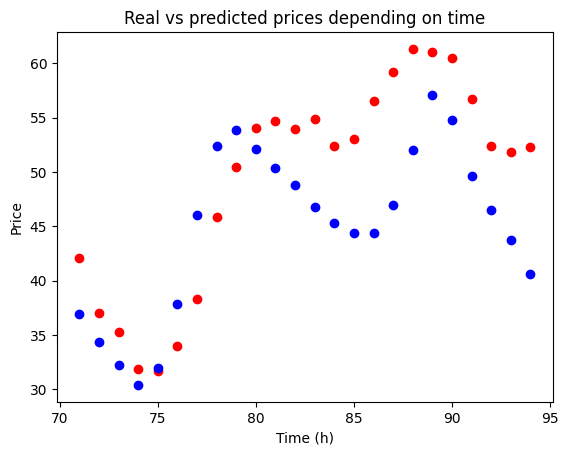

In [13]:
plt.scatter(x_test_total_hours, y_test, color = 'r')
plt.scatter(x_test_total_hours, predictions, color = 'b')
plt.title('Real vs predicted prices depending on time')
plt.xlabel('Time (h)')
plt.ylabel('Price')

plt.show()

With provided augmented data

In [14]:
# for all files in the directory
import os
import pandas as pd
from tqdm import tqdm

directory = "../data/scenarios synthetiques/prix/"

# read all files in the directory panda
xgb_model = None
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".parquet"):
        df = pd.read_parquet(directory + filename)
        X_train, y_train, X_test, y_test = split_data(df, 24, ["dayofweek", "hourofday"], "price")
        
        if xgb_model is None:
            xgb_model = xgb.XGBRegressor(**reg_cv.best_params_)
            xgb_model.fit(X_train, y_train)
        else:
            xgb_model.fit(X_train, y_train, xgb_model=xgb_model)  


100%|██████████| 154/154 [02:00<00:00,  1.28it/s]


MSE: 285.06583400778845


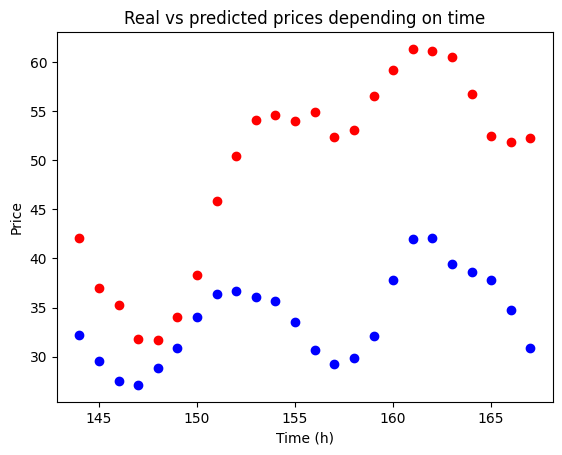

In [17]:
_, y_train, _, y_test = split_data(df_price, 24, ["dayofweek", "hourofday"], "price")

predictions = xgb_model.predict(X_test)
print("MSE:", mean_squared_error(y_test, predictions))

x_test_total_hours = X_test["dayofweek"]*24 + X_test["hourofday"]
plt.scatter(x_test_total_hours, y_test, color = 'r')
plt.scatter(x_test_total_hours, predictions, color = 'b')
plt.title('Real vs predicted prices depending on time')
plt.xlabel('Time (h)')
plt.ylabel('Price')

plt.show()